# Projet IA - Modèle d'Ising 2D - 2023/2024
Sorbonne Université - Master 1 - Physique Fondamentale et Applications

Guilherme Carvalho - Anatole Cremel-Schlemer - Panet Mathis

## Introduction - Code necessaire

In [29]:
# Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.utils import plot_model

# Dossier de travail
file_dir = "./data/"

In [30]:
# Importation des données fournis
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
print("Données importées")

Données importées


## Partie 1 : Génération de données

In [31]:
# Symétrisation des données (cf. Partie 2)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)

In [32]:
# Importation des données générées

new_data = np.load("./new_data_accelerated.npy")

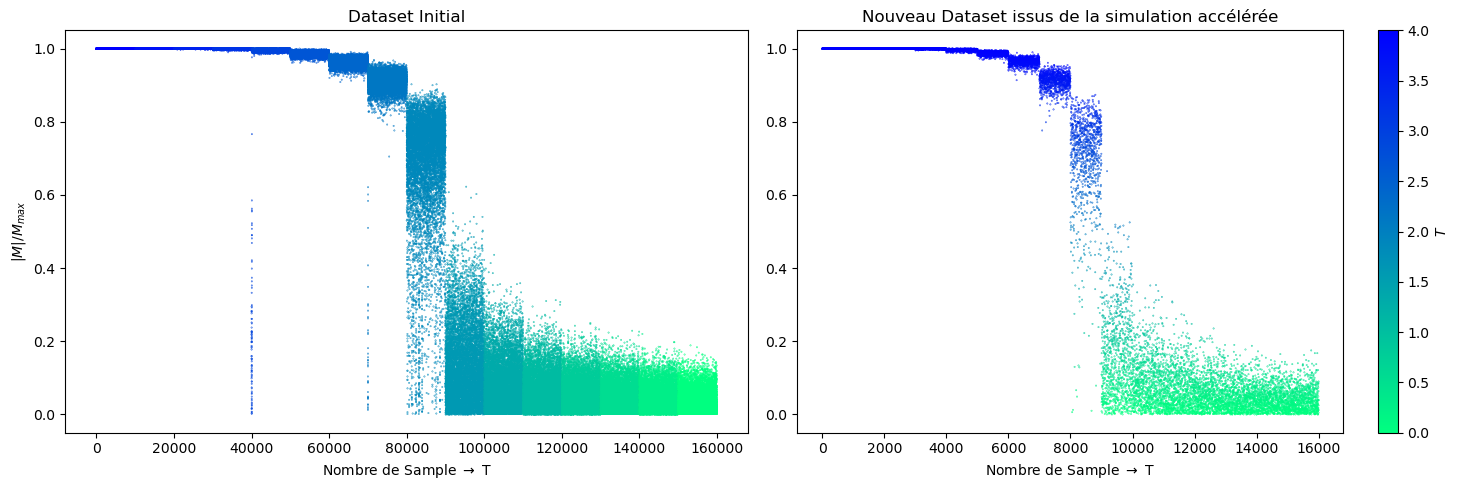

In [5]:
# Figure 1.6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cmap = mpl.colormaps['winter']
axs[0].scatter(range(tot_data_sym.shape[0]), tot_data_sym, c=tot_label, cmap=cmap, s=0.1)
axs[0].set_ylabel(r'$|M|/M_{max}$')
axs[0].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[0].set_title(r'Dataset Initial')

cmap = mpl.colormaps['winter_r']
axs[1].scatter(range(new_data.shape[0]), new_data, c=new_data, cmap=cmap, s=0.1)
axs[1].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[1].set_title(r'Nouveau Dataset issus de la simulation accélérée')

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap=cmap), ax=axs[1], label=r'$T$')
plt.tight_layout()
plt.show()

## Partie 2 : Pré-traitement des données

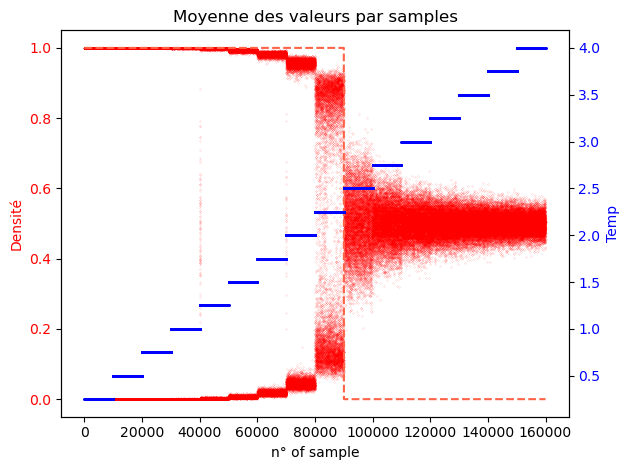

In [6]:
# Figure 2.1a
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

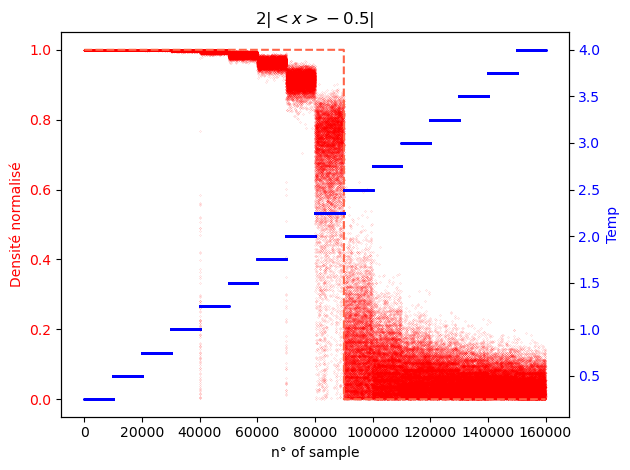

In [7]:
# Figure 2.1b
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## Partie 3 : Modèles classiques

### 3.1 Analyse par la magnétisation

In [ ]:
# Mpdèle naif
mean_temperature = np.mean(tot_label)
predictions = np.full_like(tot_label, mean_temperature)

# Calculate the mean squared error
mse = mean_squared_error(tot_label, predictions)
print("MSE:", mse)


In [ ]:
# Model linéaire sur les spins 
tot_data_sym_dim = np.c_[tot_data_sym.reshape(-1, 1), (tot_data_sym.reshape(-1, 1))**2, (tot_data_sym.reshape(-1, 1))**3, (tot_data_sym.reshape(-1, 1))**4]
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym_dim, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE :", mse)

In [8]:
# Modèle de Forêt Aléatoire
T_C = 2.269

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Créer le modèle de régression de forêt aléatoire
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Adapter le modèle aux données d'entraînement
forest_model.fit(X_train, y_train)

# Prédire sur les données de test
predictions = forest_model.predict(X_test)

# Classe réelle
real_class = np.where(y_test>T_C, 1, 0)

# Classe prédite
pred_class = np.where(predictions>T_C, 1, 0)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)

kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

mse: 0.10818591275723048


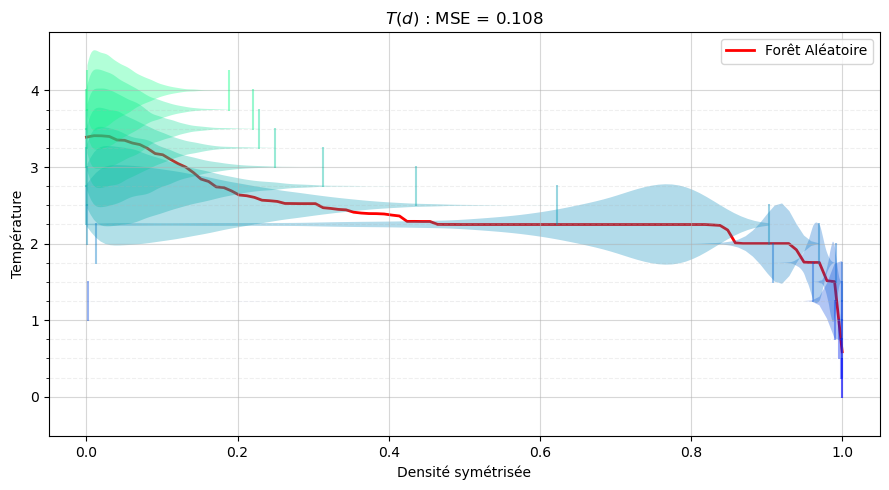

In [9]:
# Figure 3.1a
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Changer les couleurs en utilisant cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Changer l'épaisseur de ligne et l'opacité de la ligne
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Ajouter la ligne de la forêt aléatoire
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Forêt Aléatoire")

# Créer la légende
ax.legend()

# Ajouter des ticks mineurs à l'axe y
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisée")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Ajouter une grille aux ticks majeurs et mineurs
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

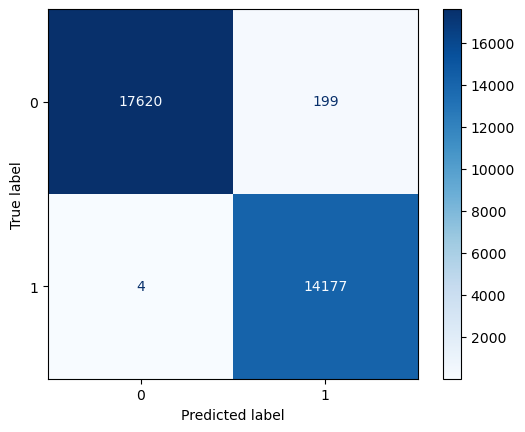

In [10]:
# Figure 3.1b
conf_mat = confusion_matrix(real_class, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

### 3.2 : Analyse par les spins

In [33]:
# Modele naif

percentage_class_1 = data_label[data_label == 1].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 1 : {percentage_class_1*100:.2f}%")
percentage_class_0 = data_label[data_label == 0].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 0 : {percentage_class_0*100:.2f}%")

# Create a naive model
def naive_model():
    if np.random.uniform() < percentage_class_1:
        return 1
    else:
        return 0

# Test the naive model
predictions = [naive_model() for _ in range(data_label.shape[0])]

print("MSE:", mean_squared_error(data_label, predictions))
print("Accuracy:", np.mean(data_label == predictions))

Pourcentage de classe 1 : 56.25%
Pourcentage de classe 0 : 43.75%
MSE: 0.49225625
Accuracy: 0.50774375


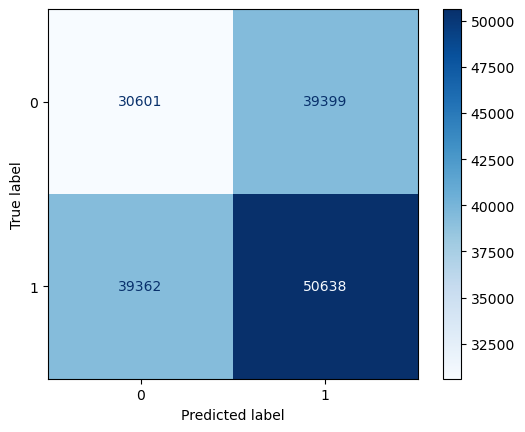

In [34]:
conf_mat = confusion_matrix(data_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.savefig("random_matrix.png", dpi=300)
plt.show()

## Partie 4 : Réseaux de neurones

In [11]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255

(160000, 40, 40)

In [12]:
# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=(40, 40, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

2023-12-15 22:46:06.375886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 22:46:06.645494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 22:46:06.646129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

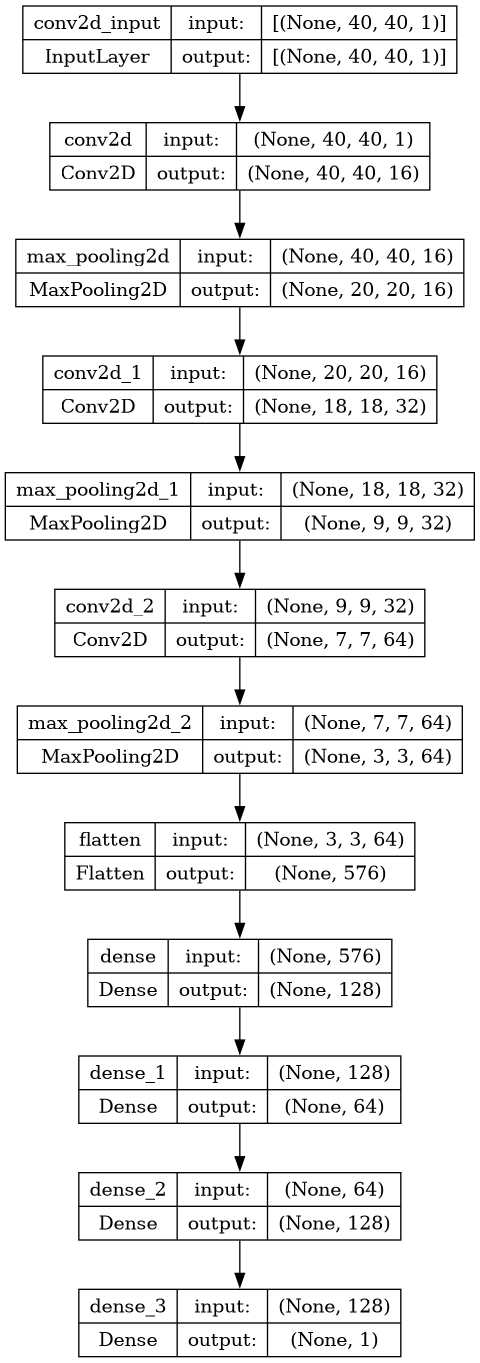

In [19]:
# Figure 4.1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks = [callback])

Epoch 1/30


2023-12-15 22:46:08.457248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-15 22:46:10.376957: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7284ad3f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 22:46:10.376977: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-12-15 22:46:10.399858: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-15 22:46:10.525923: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 7s 4ms/step - loss: 0.0183 - accuracy: 0.9935 - precision: 0.9968 - recall: 0.9917 - auc: 0.9995 - val_loss: 0.0108 - val_accuracy: 0.9965 - val_precision: 0.9948 - val_recall: 0.9990 - val_auc: 0.9999
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.9970 - precision: 0.9981 - recall: 0.9966 - auc: 0.9998 - val_loss: 0.0120 - val_accuracy: 0.9966 - val_precision: 1.0000 - val_recall: 0.9939 - val_auc: 0.9995
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0068 - accuracy: 0.9976 - precision: 0.9984 - recall: 0.9974 - auc: 0.9999 - val_loss: 0.0066 - val_accuracy: 0.9977 - val_precision: 0.9998 - val_recall: 0.9960 - val_auc: 0.9998
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0059 - accuracy: 0.9980 - precision: 0.9986 - recall: 0.9978 - auc: 0.9999 - val_loss: 0.0048 - val_accuracy: 0.9982 - val_precision: 0.9997 - val_recall: 0.9971 - val

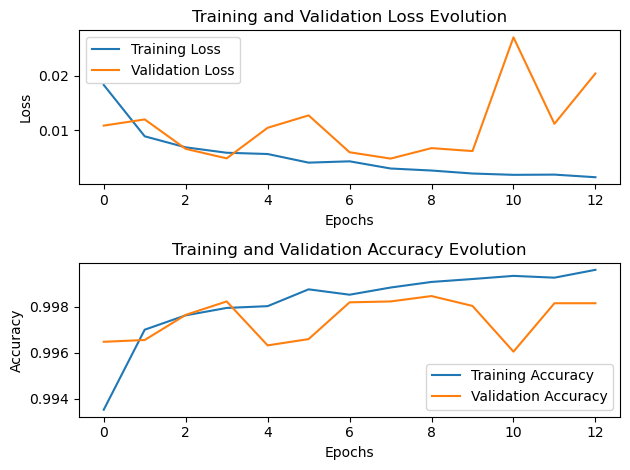

In [15]:
# Figure 4.2
plt.subplot(211)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Evolution')

plt.tight_layout()
plt.show()

In [16]:
# Affichage des métriques
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print('test loss', test_loss)
print('test accuracy', test_accuracy)
print('test precision', test_precision)
print('test recall', test_recall)
print('test auc', test_auc)

1000/1000 [==============================] - 2s 1ms/step - loss: 0.0200 - accuracy: 0.9982 - precision: 0.9995 - recall: 0.9971 - auc: 0.9990
test loss 0.0199674554169178
test accuracy 0.9981562495231628
test precision 0.999549925327301
test recall 0.9971379041671753
test auc 0.9989937543869019


1000/1000 [==============================] - 1s 757us/step


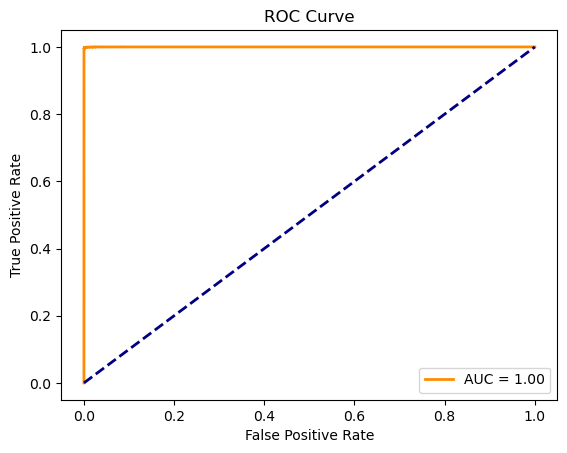

In [17]:
# Figure 4.4
y_pred = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

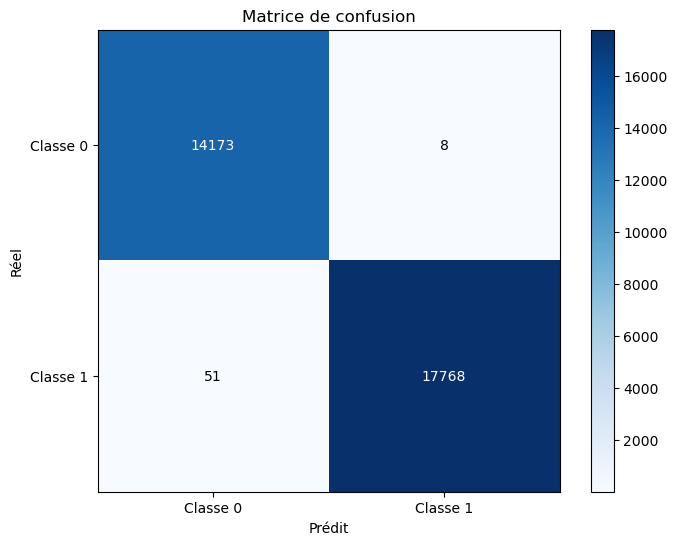

In [18]:
# Figure 4.5
y_pred.reshape(32000,)

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Prédit')
plt.ylabel('Réel')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()